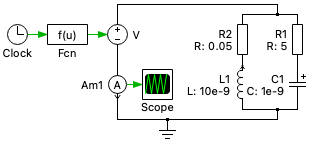

#### A circuit model of an LC bandpass filter
Originally implemented in PLECS, then compared with Julia ACME.jl package.
This model determines the current drawn from the voltage source for a Gaussian
voltage pulse aplied as an input to the filter.

The goal is to use automatic differentiation to calculate $\partial i/\partial v$ which is needed
for the nonlinear Finite Element Method.

In [1]:
using ACME

cir = @circuit begin
    v  = voltagesource(), [-] == gnd
    i  = currentprobe(),  [-] == gnd
    r1 = resistor(5.00),  [1] == v[+]
    c1 = capacitor(1e-9), [1] == r1[2], [2] == i[+]
    r2 = resistor(5e-2),  [1] == v[+]
    l1 = inductor(10e-9), [1] == r2[2], [2] == i[+]
end
nothing

In [2]:
Δt = 0.01e-9
model = DiscreteModel(cir, Δt)
nothing

In [3]:
t = range(0.0, 1.5e-6, step=Δt)
u = [exp(-(ti - 1e-7)^2 / 3e-16) for ti in t]
y = run!(model, [ui for c in 1:1, ui in u])

1×150001 Matrix{Float64}:
 6.6865e-16  6.75127e-16  6.81651e-16  …  0.00280499  0.00280485  0.00280471

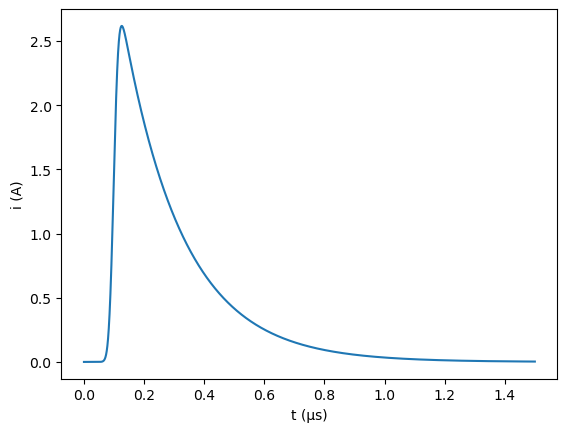

In [4]:
using PyPlot
plot(1e6t, y[:])
xlabel("t (μs)")
ylabel("i (A)")
nothing

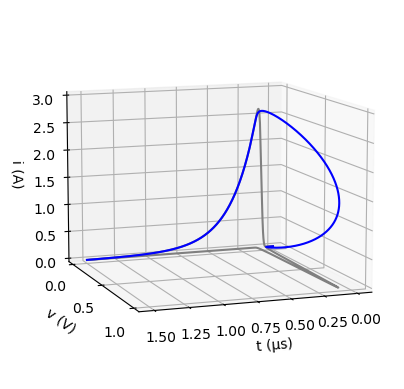

In [5]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot3D(1e6t, u[:], 0.0t, "gray")
ax.plot3D(1e6t, 0.0t, y[:], "gray")
ax.plot3D(1e6t, u[:], y[:], "blue")
yticks(0:0.5:1)
zticks(0:0.5:3)
xlabel("t (μs)")
ylabel("v (V)")
zlabel("i (A)")
ax.view_init(10, 70)

#### Custom and naive dual number implementation
We are defining a basic set of operations on dual numbers which allow for easy automatic differentiation.

In [6]:
struct Dual{T <:Number} <:Number
     v::T
    dv::T
end

import Base: +, -, *, /
-(x::Dual)          = Dual(-x.v,       -x.dv)
+(x::Dual, y::Dual) = Dual( x.v + y.v,  x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v,  x.dv - y.dv)
*(x::Dual, y::Dual) = Dual( x.v * y.v,  x.dv * y.v + x.v * y.dv)
/(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)

import Base: abs, sin, cos, tan, exp, log, sqrt, isless
abs(x::Dual)  = Dual(abs(x.v),sign(x.v)*x.dv)
sin(x::Dual)  = Dual(sin(x.v), cos(x.v)*x.dv)
cos(x::Dual)  = Dual(cos(x.v),-sin(x.v)*x.dv)
tan(x::Dual)  = Dual(tan(x.v), one(x.v)*x.dv + tan(x.v)^2*x.dv)
exp(x::Dual)  = Dual(exp(x.v), exp(x.v)*x.dv)
log(x::Dual)  = Dual(log(x.v), x.dv/x.v)
sqrt(x::Dual) = Dual(sqrt(x.v),.5/sqrt(x.v) * x.dv)
isless(x::Dual, y::Dual) = x.v < y.v;

import Base: convert, promote_rule
convert(::Type{Dual{T}}, x::Dual) where T = Dual(convert(T, x.v), convert(T, x.dv))
convert(::Type{Dual{T}}, x::Number) where T = Dual(convert(T, x), zero(T))
promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} = Dual{promote_type(T,R)}

import Base: show
show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ε]");
value(x::Dual) = x.v;
partials(x::Dual) = x.dv;

ε = Dual(0., 1.)

(0.0) + [1.0ε]

#### Automatic Differentiation of ACME.jl model
Let's try to differentiate the circuit using ACME.jl.

In [7]:
include("circuit-model.jl");

A, B, C, Di, Ei, Fi,
_, _, _, Dq, Eq, Fq = matrices(cir, Δt, 2)
x̄, y, ū, q̄, z = states(B, C, Di, Dq; T=Dual{Float64})
nothing
Dq

0×1 SMatrix{0, 1, Float64, 0} with indices SOneTo(0)×SOneTo(1)

In [8]:
m = DifferentiableModel(A, B, C, Di, Ei, Fi, Dq, Eq, Fq, x̄, y, ū, q̄, z)
Δ = 1e-5

us = similar(t)
ys = similar(t)
dydu = similar(t)
didv = similar(t)
for i in 1:length(t)
    x̄ = copy(m.x̄)
    y = copy(m.y)
    ū = copy(m.ū)
    q̄ = copy(m.q̄)
    z = copy(m.z)
    
    step!(m, u[i] + Δ)
    didv[i] = value(first(m.y))
    
    m.x̄ .= x̄
    m.y .= y
    m.ū .= ū
    m.q̄ .= q̄
    m.z .= z
    
    step!(m, u[i] - Δ)
    didv[i]-= value(first(m.y))
    
    m.x̄ .= value.(x̄)
    m.y .= value.(y)
    m.ū .= value.(ū)
    m.q̄ .= value.(q̄)
    m.z .= value.(z)
    
    step!(m, u[i] + ε)
    us[i] = value(first(m.ū))
    ys[i] = value(first(m.y))
    dydu[i] = partials(first(m.y))
    
    didv[i]/= 2Δ
end

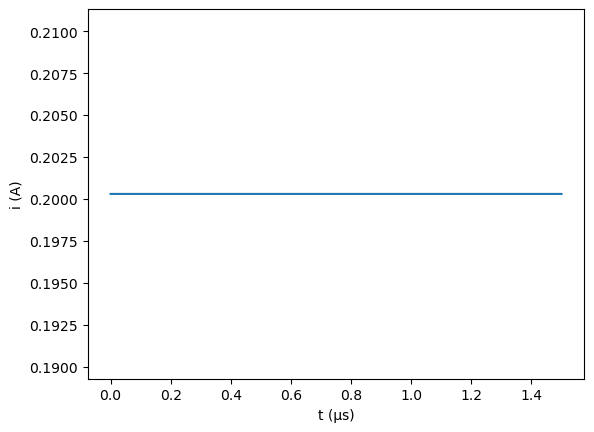

0.2003001873005123

In [9]:
using PyPlot
plot(1e6t, dydu[:])
xlabel("t (μs)")
ylabel("i (A)")
dydu[1]

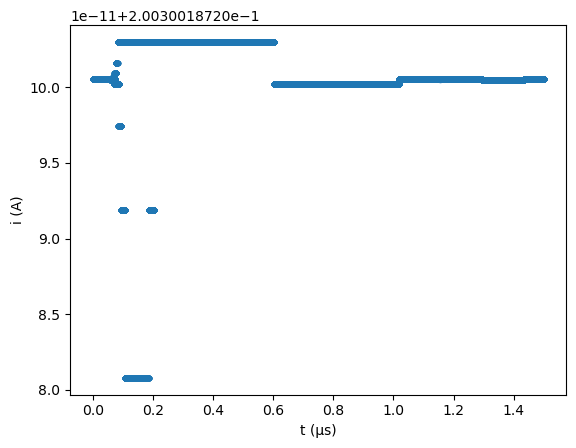

In [10]:
using PyPlot
plot(1e6t, didv[:], ".")
xlabel("t (μs)")
ylabel("i (A)")
nothing

#### Finite-Difference of ACME.jl model
As the last resort we can use Finite-Difference approximation of the derivative. Let's 

In [11]:
import Base

Δu = 1e-10
model = DiscreteModel(cir, Δt)
copied = DiscreteModel(cir, Δt)

Base.copy!(dst::T, src::T) where T = for k ∈ fieldnames(T)
  if typeof(getfield(src, k)) <: Array
    copy!(getfield(dst, k), getfield(src, k))
  end
end

ud = similar(t)
yd = similar(t)
zd = similar(t)
dy = similar(t)
for i in 1:length(t)
    copy!(copied, model)
    ui = u[i]
    uj = ui + Δu
    
    yi = run!(model,  ui * ones(1,1))[1]
    yj = run!(copied, uj * ones(1,1))[1]
    dudy = (yj - yi) / (uj - ui)
    
    ud[i]  = ui
    yd[i]  = yi
    zd[i]  = yj
    dy[i] = dudy
end

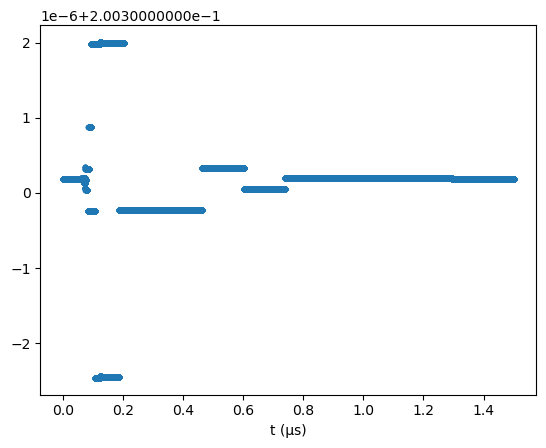

In [12]:
plot(1e6t, dy, ".")
xlabel("t (μs)");

#### PLECS generated model
The following model (described as a system of ordinary equations) has been manually reimplemented in Julia based on a code generated with PLECS 4.5.8. It should be easier for automatic differentiation.

In [13]:
mutable struct ElectricDevice{D, T}
    it :: Int
    A  :: Matrix{T}
    B0 :: Matrix{T}
    B1 :: Matrix{T}
    xp :: Vector{T}
    up :: Vector{T}
    x  :: Vector{T}
    u  :: Vector{T}
    y  :: Vector{T}
end

function ElectricDevice{D, T}(A, B0, B1) where {D, T}
    N, M = size(B0[:,:])
    device = ElectricDevice{D, T}(
        0, zeros(T, N, N), zeros(T, N, M), zeros(T, N, M),
        zeros(T, N), zeros(T, M),
        zeros(T, N), zeros(T, M), zeros(T, M)
    )
    device.A  .= A
    device.B0 .= B0
    device.B1 .= B1
    return device
end

import Base
function Base.copy(src :: ElectricDevice{D, T}) where {D, T}
    A  = similar(src.A)
    B0 = similar(src.B0)
    B1 = similar(src.B1)
    dst = ElectricDevice{D, T}(A, B0, B1)
    copy!(dst, src)
    return dst
end

function Base.copy!(dst :: ElectricDevice{D, T}, src :: ElectricDevice{D, T}) where {D, T}
    dst.A  .= src.A
    dst.B0 .= src.B0
    dst.B1 .= src.B1
    dst.xp .= src.xp
    dst.up .= src.up
    dst.x  .= src.x
    dst.u  .= src.u
    dst.y  .= src.y
    return dst
end

function init!(state :: ElectricDevice{:LC, T}) where {T}
    state.it = 0
    state.x .= [0.0, 0.0]
    return nothing
end

function update!(state :: ElectricDevice{:LC, T}) where {T}
    x = state.x
    u = state.u
    A = state.A
    
    B0, B1 = state.B0, state.B1
    xp, up = state.xp, state.up
    
    x .=  A * xp .+ B0 * up .+ B1 * u
    return nothing
end

function step!(state :: ElectricDevice{:LC, T}, excitation) where {T}
    u = state.u .= excitation
    x = state.x
    y = state.y
    
    if state.it > 0
        update!(state)
    end
    
    y[1] = 1.0 * x[1] + 0.2 * x[2] - 0.2 * u[1]
    state.up .= u
    state.xp .= x
    state.it += 1
    
    return y
end

step! (generic function with 4 methods)

In [14]:
A =  [ 0.999950001249979126 0.0;
       0.0 0.998001998667333079]
B0 = [-0.000499983333645829132;
       0.000998667666133551055]
B1 = [-0.000499991666770832209;
       0.000999333666533382126]
LC = ElectricDevice{:LC, Dual{Float64}}(A, B0, B1);

In [15]:
nt = 150_000
tp = range(0, stop=nt-1) * 0.01e-9
up = [exp(-(t - 1e-7)^2 / 3e-16) for t in tp]
yp = similar(tp)

init!(LC)
for i=1:nt
    y = step!(LC, up[i] + ε)
    yp[i,:] .= partials.(y)
end

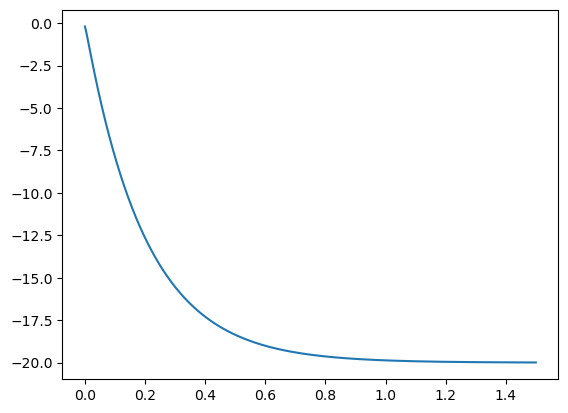

In [16]:
using PyPlot
plot(1e6tp, yp);

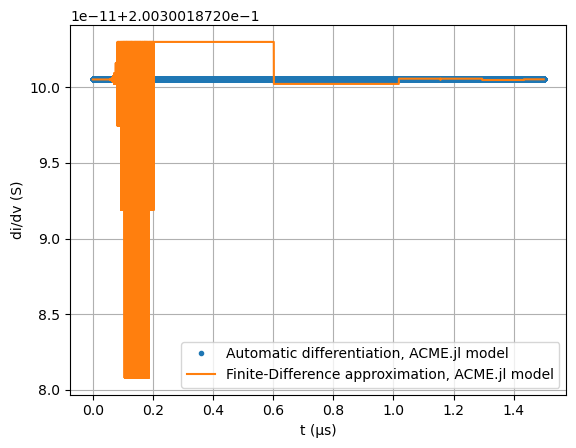

In [17]:
#plot(1e6tp, -yp)
plot(1e6t,  dydu, ".")
plot(1e6t,  didv)
xlabel("t (μs)")
ylabel("di/dv (S)")
legend(("Automatic differentiation, ACME.jl model",
        "Finite-Difference approximation, ACME.jl model"))
grid()